In [1]:
import torch
import torch.nn as nn
from hyperparams_and_args import get_argparser
from ninolearn.IO.read_processed import data_reader

from data_handling.data_handler_CNN_data import IndexLoader
from GNN_exp1.train_single_step import main, evaluate, evaluate_index
from plotting import plot_time_series, heatmap_of_edges
from utils import read_ssta
import warnings
warnings.filterwarnings("ignore")  # or use: "once"

In [10]:
data_dir = r'C:/Users/salva/OneDrive/Documentos/Projects/ProjectX/Data/'
model_dir = "models/exp1/"

In [20]:
train_dates=("1871-01", "1972-12")
val_dates=("1973-01", "1983-12")
test_dates=("1984-01", "2020-08")
parser = get_argparser(experiment="ERSSTv5")
args = parser.parse_args("")
args.data_dir = data_dir
args.batch_size = 32
args.resolution = 5
args.lon_min = 190
args.lon_max = 240
args.lat_min = -5
args.lat_max = 5
args.window = 3
args.epochs = 150
args.layers = 2
args.lr = 1e-4
args.prelu = True
args.dropout = 0.1

In [4]:
def train_exp1(args, reader):
    print(f"#Lead months = {args.horizon}, #layers = {args.layers}, Inputs between "
          f"{args.lat_min} to {args.lat_max} latitude and {args.lon_min} to {args.lon_max} longitude "
          f"for the past {args.window} months")

    flattened_ssta, train_mask = read_ssta(data_dir=args.data_dir, index=args.index, get_mask=True, resolution=args.resolution, reader=reader)
    args.mask = train_mask

    print("Model will be saved in", args.save)
    main(args, adj=None, train_dates=train_dates, val_dates=val_dates, test_dates=test_dates)  # learn edges


In [5]:
def eval_model(args, test_set="ERSSTv5"):
    model = torch.load(args.save)
    model.eval()

    evaluateL2 = nn.MSELoss().to(args.device)
    evaluateL1 = nn.L1Loss().to(args.device)

    Data = IndexLoader(args, test_set=test_set, start_date="1984-01", end_date="2020-08", data_dir=data_dir)
    if test_set == "ERSSTv5":
        test_acc, test_rae, test_corr, oni_test_stats, preds, Ytrue = evaluate(Data, Data.test[0], Data.test[1],
                                                                               model, evaluateL2, evaluateL1, args,
                                                                               return_oni_preds=True)
    else:
        test_acc, test_rae, test_corr, oni_test_stats, preds, Ytrue = evaluate_index(Data, Data.test[0], Data.test[1],
                                                                                     model, evaluateL2, evaluateL1,
                                                                                     args,
                                                                                     return_oni_preds=True)

    print(test_set, " test stats... OVERALL: rse {:5.4f} , RMSE {:5.4f} , corr {:5.4f}"
                    " | ONI:  RMSE {:5.4f} , corr {:5.4f}"
          .format(test_acc, test_rae, test_corr, oni_test_stats["RMSE"], oni_test_stats["Corrcoef"]))
    return preds, Ytrue, Data.semantic_time_steps

In [6]:
def train_and_eval(args):
    reader = data_reader(data_dir=data_dir,
                         startdate=train_dates[0], enddate=test_dates[1],
                         lon_min=args.lon_min, lon_max=args.lon_max,
                         lat_min=args.lat_min, lat_max=args.lat_max)

    train_exp1(args, reader=reader)

    # Eval test scores
    preds, Y, time_axis = eval_model(args, "ERSSTv5")
    _, _, _ = eval_model(args, "GODAS")

    # Plot learned edges
    heatmap_of_edges(file_path=args.save, args=args, reader=reader, index=args.index, min_weight=1e-4,
                     data_dir=args.data_dir)

    # PLot ONI timeseries
    oni_preds, oni_Y = preds.mean(axis=1), Y.mean(axis=1)
    plot_time_series(oni_Y, oni_preds, time_steps=time_axis, labels=["ERSSTv5 ONI", "GNN Forecast"],
                     ylabel=f"{args.index} index",  save_to=None)


#Lead months = 1, #layers = 2, Inputs between -5 to 5 latitude and 190 to 240 longitude for the past 3 months
Model will be saved in models/exp1/
Time series Length = 1222, Number of nodes = 33, Predict 1 time steps in advance using 3 time steps, Training set size = 1222  

The receptive field size is 19
Number of model parameters is 27969
begin training
--> Epoch   1 | time:  5.70s | train_loss 0.6379 | Val. loss 0.0110, corr 0.9004 | ONI corr 0.9029, RMSE 0.1627
Model will be saved...
--> Epoch   2 | time:  4.93s | train_loss 0.1739 | Val. loss 0.0100, corr 0.9284 | ONI corr 0.9289, RMSE 0.1510
Model will be saved...
--> Epoch   3 | time:  4.86s | train_loss 0.0916 | Val. loss 0.0064, corr 0.9588 | ONI corr 0.9620, RMSE 0.0930
Model will be saved...
--> Epoch   4 | time:  4.87s | train_loss 0.0692 | Val. loss 0.0048, corr 0.9717 | ONI corr 0.9763, RMSE 0.0650
Model will be saved...
--> Epoch   5 | time:  4.93s | train_loss 0.0582 | Val. loss 0.0043, corr 0.9777 | ONI corr 0.9824, RMS

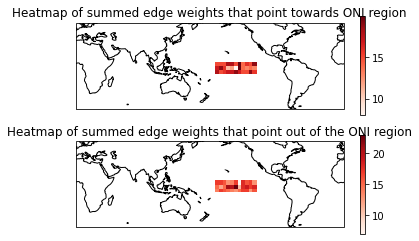

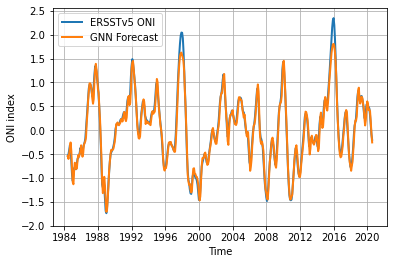

In [7]:
args.horizon = 1
args.epochs = 25
args.save = model_dir + "1mon_lead"
train_and_eval(args)

#Lead months = 3, #layers = 2, Inputs between -5 to 5 latitude and 190 to 240 longitude for the past 3 months
Model will be saved in models/exp1/3mon_lead
Time series Length = 1222, Number of nodes = 33, Predict 3 time steps in advance using 3 time steps, Training set size = 1222  

The receptive field size is 19
Number of model parameters is 27969
begin training
--> Epoch   1 | time:  1.70s | train_loss 0.7300 | Val. loss 0.0085, corr 0.7657 | ONI corr 0.7803, RMSE 0.2585
Model will be saved...
--> Epoch   2 | time:  1.69s | train_loss 0.5401 | Val. loss 0.0083, corr 0.7925 | ONI corr 0.8075, RMSE 0.2546
Model will be saved...
--> Epoch   3 | time:  1.71s | train_loss 0.4009 | Val. loss 0.0064, corr 0.7882 | ONI corr 0.8009, RMSE 0.1907
Model will be saved...
--> Epoch   4 | time:  1.76s | train_loss 0.3380 | Val. loss 0.0056, corr 0.7929 | ONI corr 0.8050, RMSE 0.1627
Model will be saved...
--> Epoch   5 | time:  1.81s | train_loss 0.3131 | Val. loss 0.0054, corr 0.8133 | ONI corr 0.

--> Epoch  55 | time:  7.85s | train_loss 0.2030 | Val. loss 0.0040, corr 0.9034 | ONI corr 0.9212, RMSE 0.1054
Model will be saved...
-------> Test stats: rse 0.0074 | rae 0.0001 | corr 0.8748 | ONI corr 0.8944 | ONI RMSE 0.2045
--> Epoch  56 | time:  7.84s | train_loss 0.2020 | Val. loss 0.0040, corr 0.9034 | ONI corr 0.9212, RMSE 0.1057
--> Epoch  57 | time:  7.93s | train_loss 0.2015 | Val. loss 0.0040, corr 0.9036 | ONI corr 0.9214, RMSE 0.1054
--> Epoch  58 | time:  7.88s | train_loss 0.2019 | Val. loss 0.0040, corr 0.9039 | ONI corr 0.9216, RMSE 0.1054
--> Epoch  59 | time:  7.92s | train_loss 0.2007 | Val. loss 0.0039, corr 0.9041 | ONI corr 0.9218, RMSE 0.1052
Model will be saved...
--> Epoch  60 | time:  7.90s | train_loss 0.2018 | Val. loss 0.0040, corr 0.9039 | ONI corr 0.9216, RMSE 0.1056
-------> Test stats: rse 0.0074 | rae 0.0001 | corr 0.8757 | ONI corr 0.8954 | ONI RMSE 0.2028
--> Epoch  61 | time:  7.88s | train_loss 0.2002 | Val. loss 0.0039, corr 0.9043 | ONI corr 

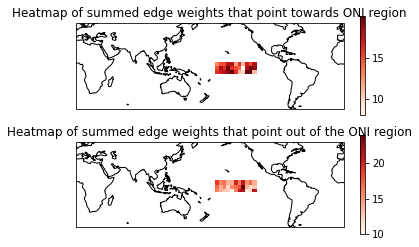

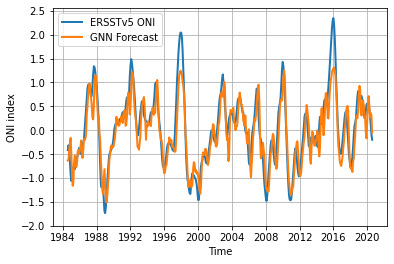

In [18]:
args.horizon = 3
args.epochs = 100
args.save = model_dir + "3mon_lead"
train_and_eval(args)

In [ ]:
args.horizon = 3
args.epochs = 100
args.save = model_dir + "3mon_lead_1d"
train_and_eval(args)

#Lead months = 3, #layers = 2, Inputs between -5 to 5 latitude and 190 to 240 longitude for the past 3 months
Model will be saved in models/exp1/3mon_lead_1d
Time series Length = 1222, Number of nodes = 33, Predict 3 time steps in advance using 3 time steps, Training set size = 1222  

The receptive field size is 19
Number of model parameters is 27969
begin training
--> Epoch   1 | time:  1.66s | train_loss 0.8139 | Val. loss 0.0076, corr 0.7623 | ONI corr 0.7740, RMSE 0.2282
Model will be saved...
--> Epoch   2 | time:  1.71s | train_loss 0.5215 | Val. loss 0.0102, corr 0.7746 | ONI corr 0.7865, RMSE 0.3169
--> Epoch   3 | time:  1.64s | train_loss 0.3617 | Val. loss 0.0067, corr 0.8182 | ONI corr 0.8306, RMSE 0.2002
Model will be saved...
--> Epoch   4 | time:  1.63s | train_loss 0.3074 | Val. loss 0.0053, corr 0.8286 | ONI corr 0.8404, RMSE 0.1516
Model will be saved...
--> Epoch   5 | time:  1.70s | train_loss 0.2878 | Val. loss 0.0050, corr 0.8410 | ONI corr 0.8530, RMSE 0.1424
Mo

--> Epoch  55 | time:  7.71s | train_loss 0.2063 | Val. loss 0.0040, corr 0.9061 | ONI corr 0.9218, RMSE 0.1063
Model will be saved...
-------> Test stats: rse 0.0075 | rae 0.0001 | corr 0.8697 | ONI corr 0.8882 | ONI RMSE 0.2098
--> Epoch  56 | time:  7.76s | train_loss 0.2064 | Val. loss 0.0040, corr 0.9060 | ONI corr 0.9217, RMSE 0.1068
--> Epoch  57 | time:  7.76s | train_loss 0.2053 | Val. loss 0.0040, corr 0.9061 | ONI corr 0.9217, RMSE 0.1064
--> Epoch  58 | time:  7.73s | train_loss 0.2055 | Val. loss 0.0040, corr 0.9061 | ONI corr 0.9217, RMSE 0.1073
--> Epoch  59 | time:  7.71s | train_loss 0.2057 | Val. loss 0.0040, corr 0.9061 | ONI corr 0.9217, RMSE 0.1074
--> Epoch  60 | time:  7.72s | train_loss 0.2052 | Val. loss 0.0040, corr 0.9061 | ONI corr 0.9217, RMSE 0.1065
-------> Test stats: rse 0.0075 | rae 0.0001 | corr 0.8697 | ONI corr 0.8883 | ONI RMSE 0.2092
--> Epoch  61 | time:  7.73s | train_loss 0.2055 | Val. loss 0.0040, corr 0.9062 | ONI corr 0.9218, RMSE 0.1067
-->

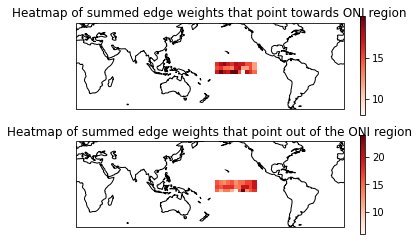

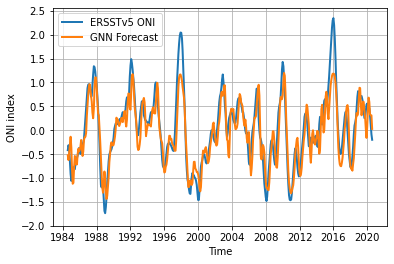

In [21]:
args.horizon = 3
args.epochs = 100
args.save = model_dir + "3mon_lead_1d"
train_and_eval(args)